<a href="https://colab.research.google.com/github/AhmedThahir/Deep_Learning_Optimization_Algorithms/blob/main/AI_Optimization_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [197]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [198]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = nn.functional.one_hot(self.y, num_classes=10).to(float)


    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

In [199]:
# https://www.di.ens.fr/~lelarge/MNIST.tar.gz
train_ds = CTDataset('./MNIST/training.pt')
test_ds = CTDataset('./MNIST/test.pt')

In [200]:
random_sampler = RandomSampler(train_ds, num_samples=10_000)

In [201]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, sampler=random_sampler)

In [202]:
class MyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(28**2,100)
        self.Matrix2 = nn.Linear(100,50)
        self.Matrix3 = nn.Linear(50,10)
        self.R = nn.ReLU()
    def forward(self,x):
        x = x.view(-1,28**2)
        x = self.R(self.Matrix1(x))
        x = self.R(self.Matrix2(x))
        x = self.Matrix3(x)
        return x.squeeze()

In [203]:
f = MyNeuralNet()

In [204]:
def train_model(dl, f, loss, optimizer, n_epochs=20):
    # Optimization
    opt = SGD(f.parameters(), lr=0.01)

    # Train model
    losses = []
    epochs = []

    N = len(dl)

    for epoch in range(1, n_epochs+1):
        for i, (x, y) in enumerate(dl):
            # Update the weights of the network
            optimizer.zero_grad()
            loss_value = loss(f(x), y)
            loss_value.backward()
            optimizer.step()
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())

        print(f'Epoch {epoch}/{n_epochs} Completed')
    return np.array(epochs), np.array(losses)

In [205]:
optimizers = """
ASGD
Adadelta
Adagrad
Adam
AdamW
Adamax
LBFGS
NAdam
Optimizer
RAdam
RMSprop
Rprop
SGD
SparseAdam
"""

optimizers = [o for o in optimizers.split("\n") if o != ""]
optimizers

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam']

In [206]:
# this is our project
optimizer = SGD(f.parameters(), lr=0.01)

In [207]:
loss = nn.CrossEntropyLoss()
n_epochs = 20

In [208]:
epoch_data, loss_data = train_model(train_dl, f, loss, optimizer, n_epochs)

Epoch 1/20 Completed
Epoch 2/20 Completed
Epoch 3/20 Completed
Epoch 4/20 Completed
Epoch 5/20 Completed
Epoch 6/20 Completed
Epoch 7/20 Completed
Epoch 8/20 Completed
Epoch 9/20 Completed
Epoch 10/20 Completed
Epoch 11/20 Completed
Epoch 12/20 Completed
Epoch 13/20 Completed
Epoch 14/20 Completed
Epoch 15/20 Completed
Epoch 16/20 Completed
Epoch 17/20 Completed
Epoch 18/20 Completed
Epoch 19/20 Completed
Epoch 20/20 Completed


In [209]:
# Average the loss across all the data per epoch to get the total loss
epoch_data_avgd = epoch_data.reshape(n_epochs,-1).mean(axis=1)
loss_data_avgd = loss_data.reshape(n_epochs,-1).mean(axis=1)

In [211]:
fig = px.line(
    x = epoch_data_avgd,
    y = loss_data_avgd,
    title = "Cross Entropy (avgd per epoch)",
    range_x = [epoch_data_avgd.min(), epoch_data_avgd.max()],
    range_y = [0, loss_data_avgd.max()*1.1],
    markers=True,
    labels = {
        "x": "Epoch",
        "y": "Loss"
    }
)
#fig.update_traces(patch={"line": {"dash": "dot"}})
fig.show()

In [212]:
test_count = 10

In [213]:
xs, ys = test_ds[:test_count] # test
yhats = f(xs).argmax(axis=1)

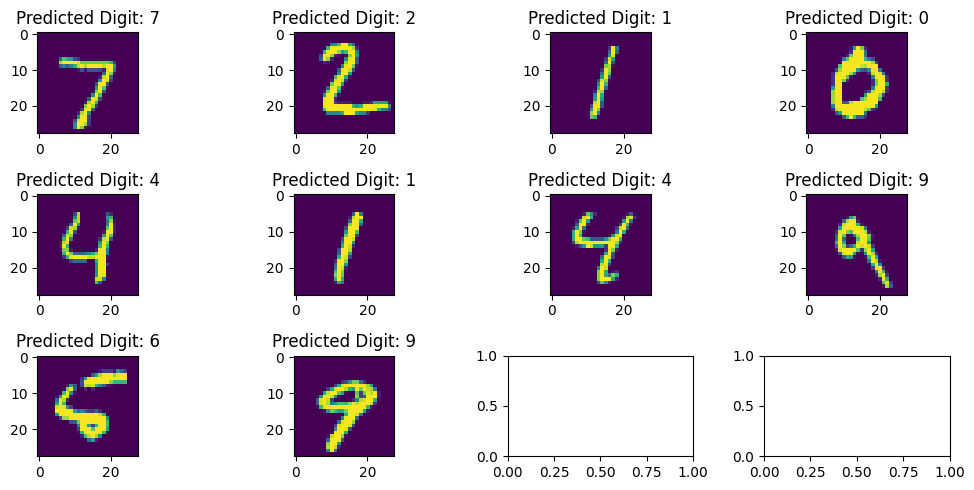

In [214]:
cols = 4
rows = np.ceil(test_count/cols).astype(int)

fig, ax = plt.subplots(rows, cols,figsize=(10,5))
for i in range(test_count):
    plt.subplot(rows, cols, i+1)
    plt.imshow(xs[i])
    plt.title(f'Predicted Digit: {yhats[i]}')
fig.tight_layout()
plt.show()